# Solving the master equation in QuTiP

Recall the Dispersive Jaynes-Cummings Hamiltonian is:

$$ 
H_{disp} = \hbar (\omega_r + \chi \sigma_z)a^{\dagger} a + \frac{\hbar}{2}(\omega_a + \chi)\sigma_z
$$

Consider applying external microwave fields:

$$
H_d = \hbar \left( \epsilon_m(t)a^{\dagger} e^{-i \omega_m t} + \Omega (t) \sigma_+ e^{-i \omega_s t} + h.c. \right)
$$

Such that the system's Hamiltonian is $H = H_{disp} + H_d$. We solve for the Hamiltonian in a rotating frame and taking $\hbar = 1$ units:

$$
H = (\Delta_{rm} + \chi \sigma_z)a^{\dagger} a + \frac{\hbar}{2}(\Delta_{as} + \chi)\sigma_z + \epsilon_m(t)(a^{\dagger}+a) + \Omega (t) \sigma_x
$$

The dynamics of the system is modelled by a Lindblad-type master equation

$$
\frac{d \rho}{dt} = -i [H, \rho] + \kappa {\mathcal{D}}[a]\rho 
+ \gamma_1 {\mathcal{D}}[\sigma_{-}]\rho + \frac{\gamma_\phi}{2}{\mathcal{D}}[\sigma_z]\rho
$$


In [2]:
from qutip import*
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# We are in a 2x2 Hilbert space, 1 qubit
# All units are in MHz, us

# conversion from ns to us
ntu = 10**(-3)

# Truncate the fock state at
N = 5

# Values obtained from the paper

wr = 2*np.pi*6443
k = 2*np.pi*1.69
wa = 2*np.pi*4009
Ec = 2*np.pi*232.5
chi = -2*np.pi*0.69
g1 = 2*np.pi*0.19
gphi = g1 #idk otherwise
epsi = np.sqrt(k/2)
wm = wr-chi
ws = (wa+2*chi*(N+0.5))


# basis states:
excited = basis(2,1)
ground = basis(2,0)


# intial state
psi0 = tensor(basis(N,0), basis(2,0))    # start with a ground state atom

# operators
a  = tensor(destroy(N), qeye(2))
sx = tensor(qeye(N), sigmax())
sz = -tensor(qeye(N), sigmaz()) # for some reason the paper defines it as such
sm = tensor(qeye(N), destroy(2))


# the pi pulse [-10ns,0ns]
def Om(t,args):
    if (t < -10*ntu) or (t > 0):
        return 0
    return 157 # this is total area 0.010*157 = 1.57 = pi/2 --> pi pulse!

# Hamiltonian in RF

H0 = (((wr-wm) + chi*sz)*(a.dag()*a) + 0.5*((wa-ws)+chi)*sz)+ epsi*(a+a.dag())
H1 = sm+sm.dag()


H = [H0,[H1,Om]]

# Collapse operators
c_ops = []
c_ops.append(np.sqrt(k)*a)
c_ops.append(np.sqrt(g1)*sm)
c_ops.append(np.sqrt(gphi/2)*sz)
 
         
times = np.linspace(-0.5, 2, 1000)
output_sz = mesolve(H, psi0, times, c_ops,sz)

## Let's make sure a pi pulse is a pi pulse

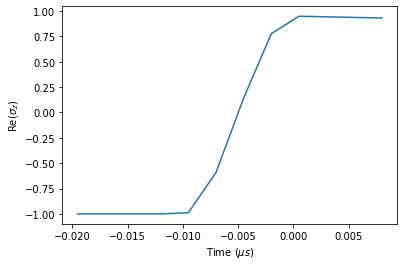

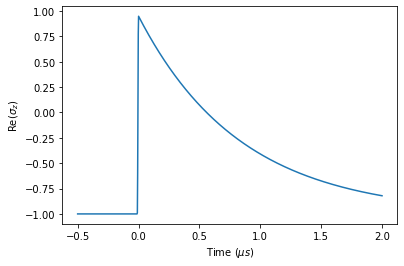

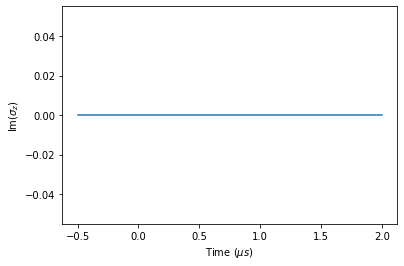

In [4]:
# let's print the pi pulse response to sigma z

res = output_sz.expect[0]

I = np.real(res)
Q = np.imag(res)

mask2 = (times > -20*ntu) == (times < 10*ntu)

plt.plot(times[mask2], I[mask2])
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Re($\sigma_z$)")
plt.show()

plt.plot(times, I)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Re($\sigma_z$)")
plt.show()


plt.plot(times, Q)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Im($\sigma_z)$")
plt.show()



## Obtain Q and I

3.141461034386498


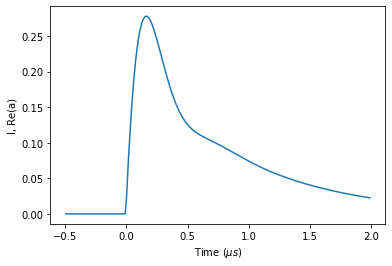

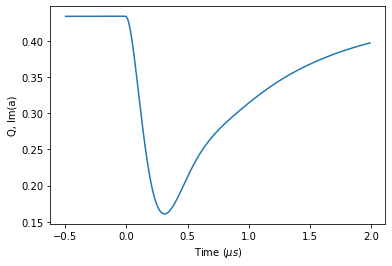

In [5]:

# -2 is the start since I want to have reached steady state by the time of pi pulse
times1 = np.linspace(-2, 7, 1000)

output_a = mesolve(H, psi0, times1, c_ops,a)

res_a = output_a.expect[0]

I_a = np.real(res_a)
Q_a = np.imag(res_a)

mask2 = (times1 > -0.5) == (times1 < 2) # slice 


# let's rotate!, we need the rotation since that is what they do in the paper

theta = np.arctan2(I_a[-1],Q_a[-1])
print(theta)

Q_a1 = Q_a*np.cos(theta) - I_a*np.sin(theta)
I_a1 = Q_a*np.sin(theta) - I_a*np.cos(theta)


plt.plot(times1[mask2], I_a1[mask2])
plt.xlabel("Time ($\mu s$)")
plt.ylabel("I, Re(a)")
plt.show()


plt.plot(times1[mask2], Q_a1[mask2])
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Q, Im(a)")
plt.show()

np.savetxt('time.txt', times1[mask2], delimiter=',')
np.savetxt('Q.txt', Q_a1[mask2], delimiter=',')
np.savetxt('I.txt', I_a1[mask2], delimiter=',')
